In [95]:
from PIL import Image
%matplotlib inline
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset

In [57]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [103]:
trans = transforms.Compose([transforms.Resize((512,512)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                            ])

dataset = torchvision.datasets.ImageFolder(root = './drive/MyDrive/Colab Notebooks/image', transform = trans)
print(len(dataset))
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)

1494
1120
374
Dataset ImageFolder
    Number of datapoints: 1494
    Root location: ./drive/MyDrive/Colab Notebooks/image
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [104]:
trainloader = DataLoader(datasets['train'].dataset,
                         batch_size = 8,
                         shuffle = True,
                         num_workers = 4)

testloader = DataLoader(datasets['val'].dataset,
                         batch_size = 8,
                         shuffle = True,
                         num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [105]:
for X, y in testloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Shape of X [N, C, H, W]:  torch.Size([8, 3, 512, 512])
Shape of y:  torch.Size([8]) torch.int64


In [106]:
# 학습용 디바이스 정보 획득
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [107]:
# 모델 정의
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



In [108]:
# 모델 학습을 위한 디바이스 설정
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [109]:
# 모델 학습 솔류션 수렴을 위한 최적화 모델 정의
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [110]:
# 훈련 함수 정의
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [111]:
# 테스트 함수 정의
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 10  # 학습을 원하는 만큼 수정요
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(testloader, model)
print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

In [101]:
classes = [
    'M_acc',
    'M_wear',
    'W_wear',
    'acc',
    'bag',
    'beauty',
    'ceramic',
    'electronic',
    'golf_exercise',
    'interior',
    'nan',
    'pill_kitchen',
    'shoes',
    'used_car'
]

In [ ]:
# 모델 평가
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)  # 패션 MNIST 데이터 입력 후 예측
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

In [73]:
classes = dataset.classes
classes

['M_acc',
 'M_wear',
 'W_wear',
 'acc',
 'bag',
 'beauty',
 'ceramic',
 'electronic',
 'golf_exercise',
 'interior',
 'nan',
 'pill_kitchen',
 'shoes',
 'used_car']

In [11]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(labels)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([ 7,  6, 10,  7])


In [12]:
def imshow(img):
  img = img /2 +0.5
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1,2,0)))

  print(np_img.shape)
  print((np.transpose(np_img, (1,2,0))).shape)

torch.Size([4, 3, 100, 100])
(3, 104, 410)
(104, 410, 3)
torch.Size([4, 3, 100, 100])
torch.Size([3, 104, 410])
electronic ceramic   nan electronic 


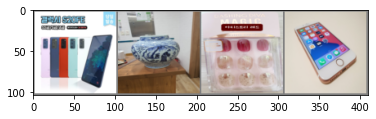

In [17]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(4)))

In [19]:
len(images)

4